In [1]:
import pandas as pd
import numpy
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
trenovacie = pd.read_csv("data/predspracovane_train.csv")

In [3]:
trenovacie['class'].unique()

array(['negative', 'increased binding protein',
       'decreased binding protein'], dtype=object)

In [4]:
cls = DecisionTreeClassifier(criterion='entropy', max_depth=5)
X = trenovacie[['TT4', 'T4U', 'T3']]
y = trenovacie['class']
cls.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [5]:
overovacie = pd.read_csv("data/predspracovane_valid.csv")
testovacie = pd.read_csv("data/predspracovane_test.csv")

In [6]:
pred = cls.predict(overovacie[['TT4', 'T4U', 'T3']])

In [7]:

accuracy_score(overovacie['class'], pred)
f1_score(overovacie['class'], pred, average='macro')


0.7248973794324268

In [8]:
X_train = trenovacie[['TT4', 'T4U', 'T3']]
y_train = trenovacie['class']
results = []
X_test = overovacie[['TT4', 'T4U', 'T3']]
y_test = overovacie['class']
estimators = []
for i in range(1, 20):
    row = {'model_complexity': i}
    # Vytvoríme rozhodovací strom
    clf = DecisionTreeClassifier(max_depth = i) # strom s maximalnou hlbkou 1-pocet atributov,  simulujeme tak zlozitost modelu

    pred = clf.fit(X_train, y_train).predict(X_train) # natrenovanie modelu a predikovanie na trenovacej sade
    row['train_kurac'] = accuracy_score(y_train, pred) # chyba na trenovacej sade
    row['train_f1'] = f1_score(y_train, pred, average='macro') # chyba na trenovacej sade

    pred = clf.predict(X_test)
    row['test_kurac'] = accuracy_score(y_test, pred) # chyba na testovacej sade
    row['test_f1'] = f1_score(y_test, pred, average='macro') # chyba na testovacej sade
    results.append(row)
    estimators.append(clf)

/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-s

In [9]:
complexity_df = pd.DataFrame(results)
complexity_df.head()

,model_complexity,test_f1,test_kurac,train_f1,train_kurac
0,1,0.492412,0.956337,0.518254,0.955484
1,2,0.510595,0.973376,0.524831,0.970170
2,3,0.510595,0.973376,0.524831,0.970170
3,4,0.723579,0.970181,0.832633,0.974759
4,5,0.747234,0.974441,0.876180,0.982561


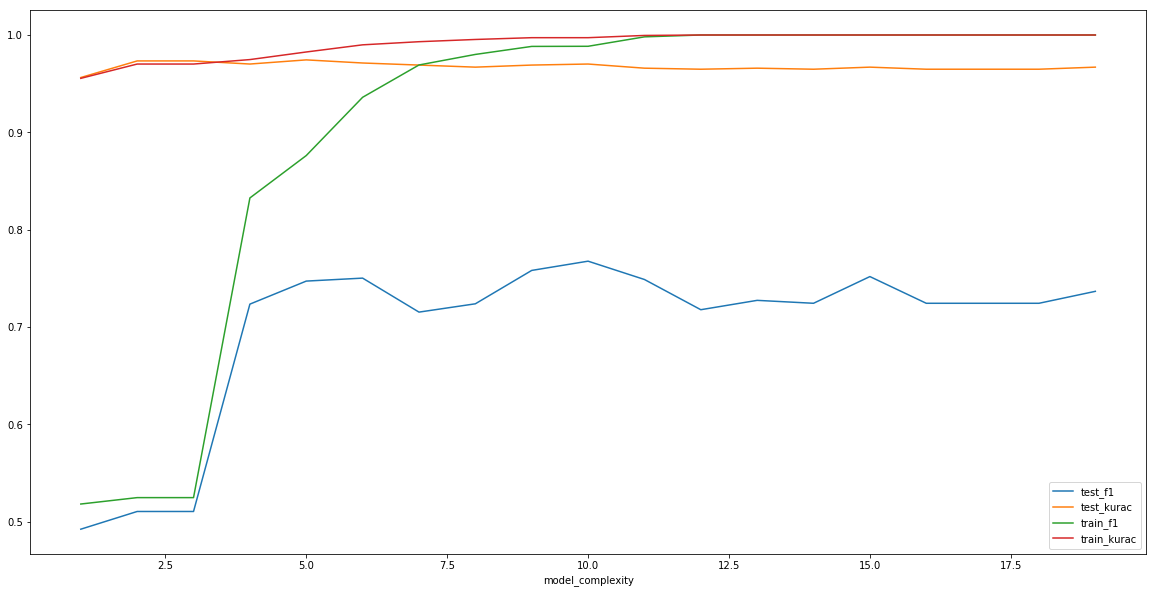

In [12]:
complexity_df.plot(x='model_complexity', figsize=(20, 10))